# PART I: Initialization

This cell must contain the location of the 'fsps' folder, which can be found inside the Dense Basis package (folder)

/.../fsps

In [1]:
%env SPS_HOME=

env: SPS_HOME=/home/aayushjoshi/DB/fsps/


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import dense_basis as db
print('DB version: ',db.__version__)

import pandas
import lsst
from lsst.rsp import get_tap_service, retrieve_query

import numpy.polynomial.polynomial as poly
import scipy.signal
from scipy.signal import find_peaks

Starting dense_basis. please wait ~ a minute for the FSPS backend to initialize.
DB version:  0.1.9


## Variable Defination

Declare input parameters:
- `z_min`: Minimum redshift
- `z_max`: Maximum redshift
- `Nparams`: Number of lookback time parameters

**Important Note: These are the parameters that determine if the data is retrieved or processed before.**

In [3]:
# REDSHIFT RANGE
z_min = 0
z_max = 0.15

# NUMBER OF LOOKBACK PARAMETERS
Nparam = 3

## Enable TAP Service

In [4]:
service = get_tap_service()
assert service is not None
assert service.baseurl == "https://data.lsst.cloud/api/tap"

## Visualize LSST Filters and transmission

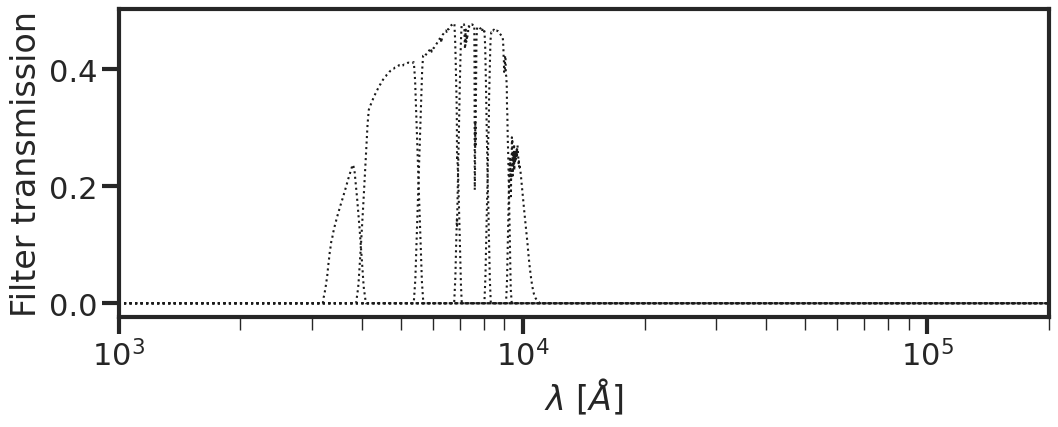

In [5]:
# filter set
filter_list = 'LSST_list.dat'
filt_dir = db.get_path(filter_list) # path to directory containing filter list
db.plot_filterset(filter_list = filter_list, filt_dir = filt_dir)

## Create Prior Distribution

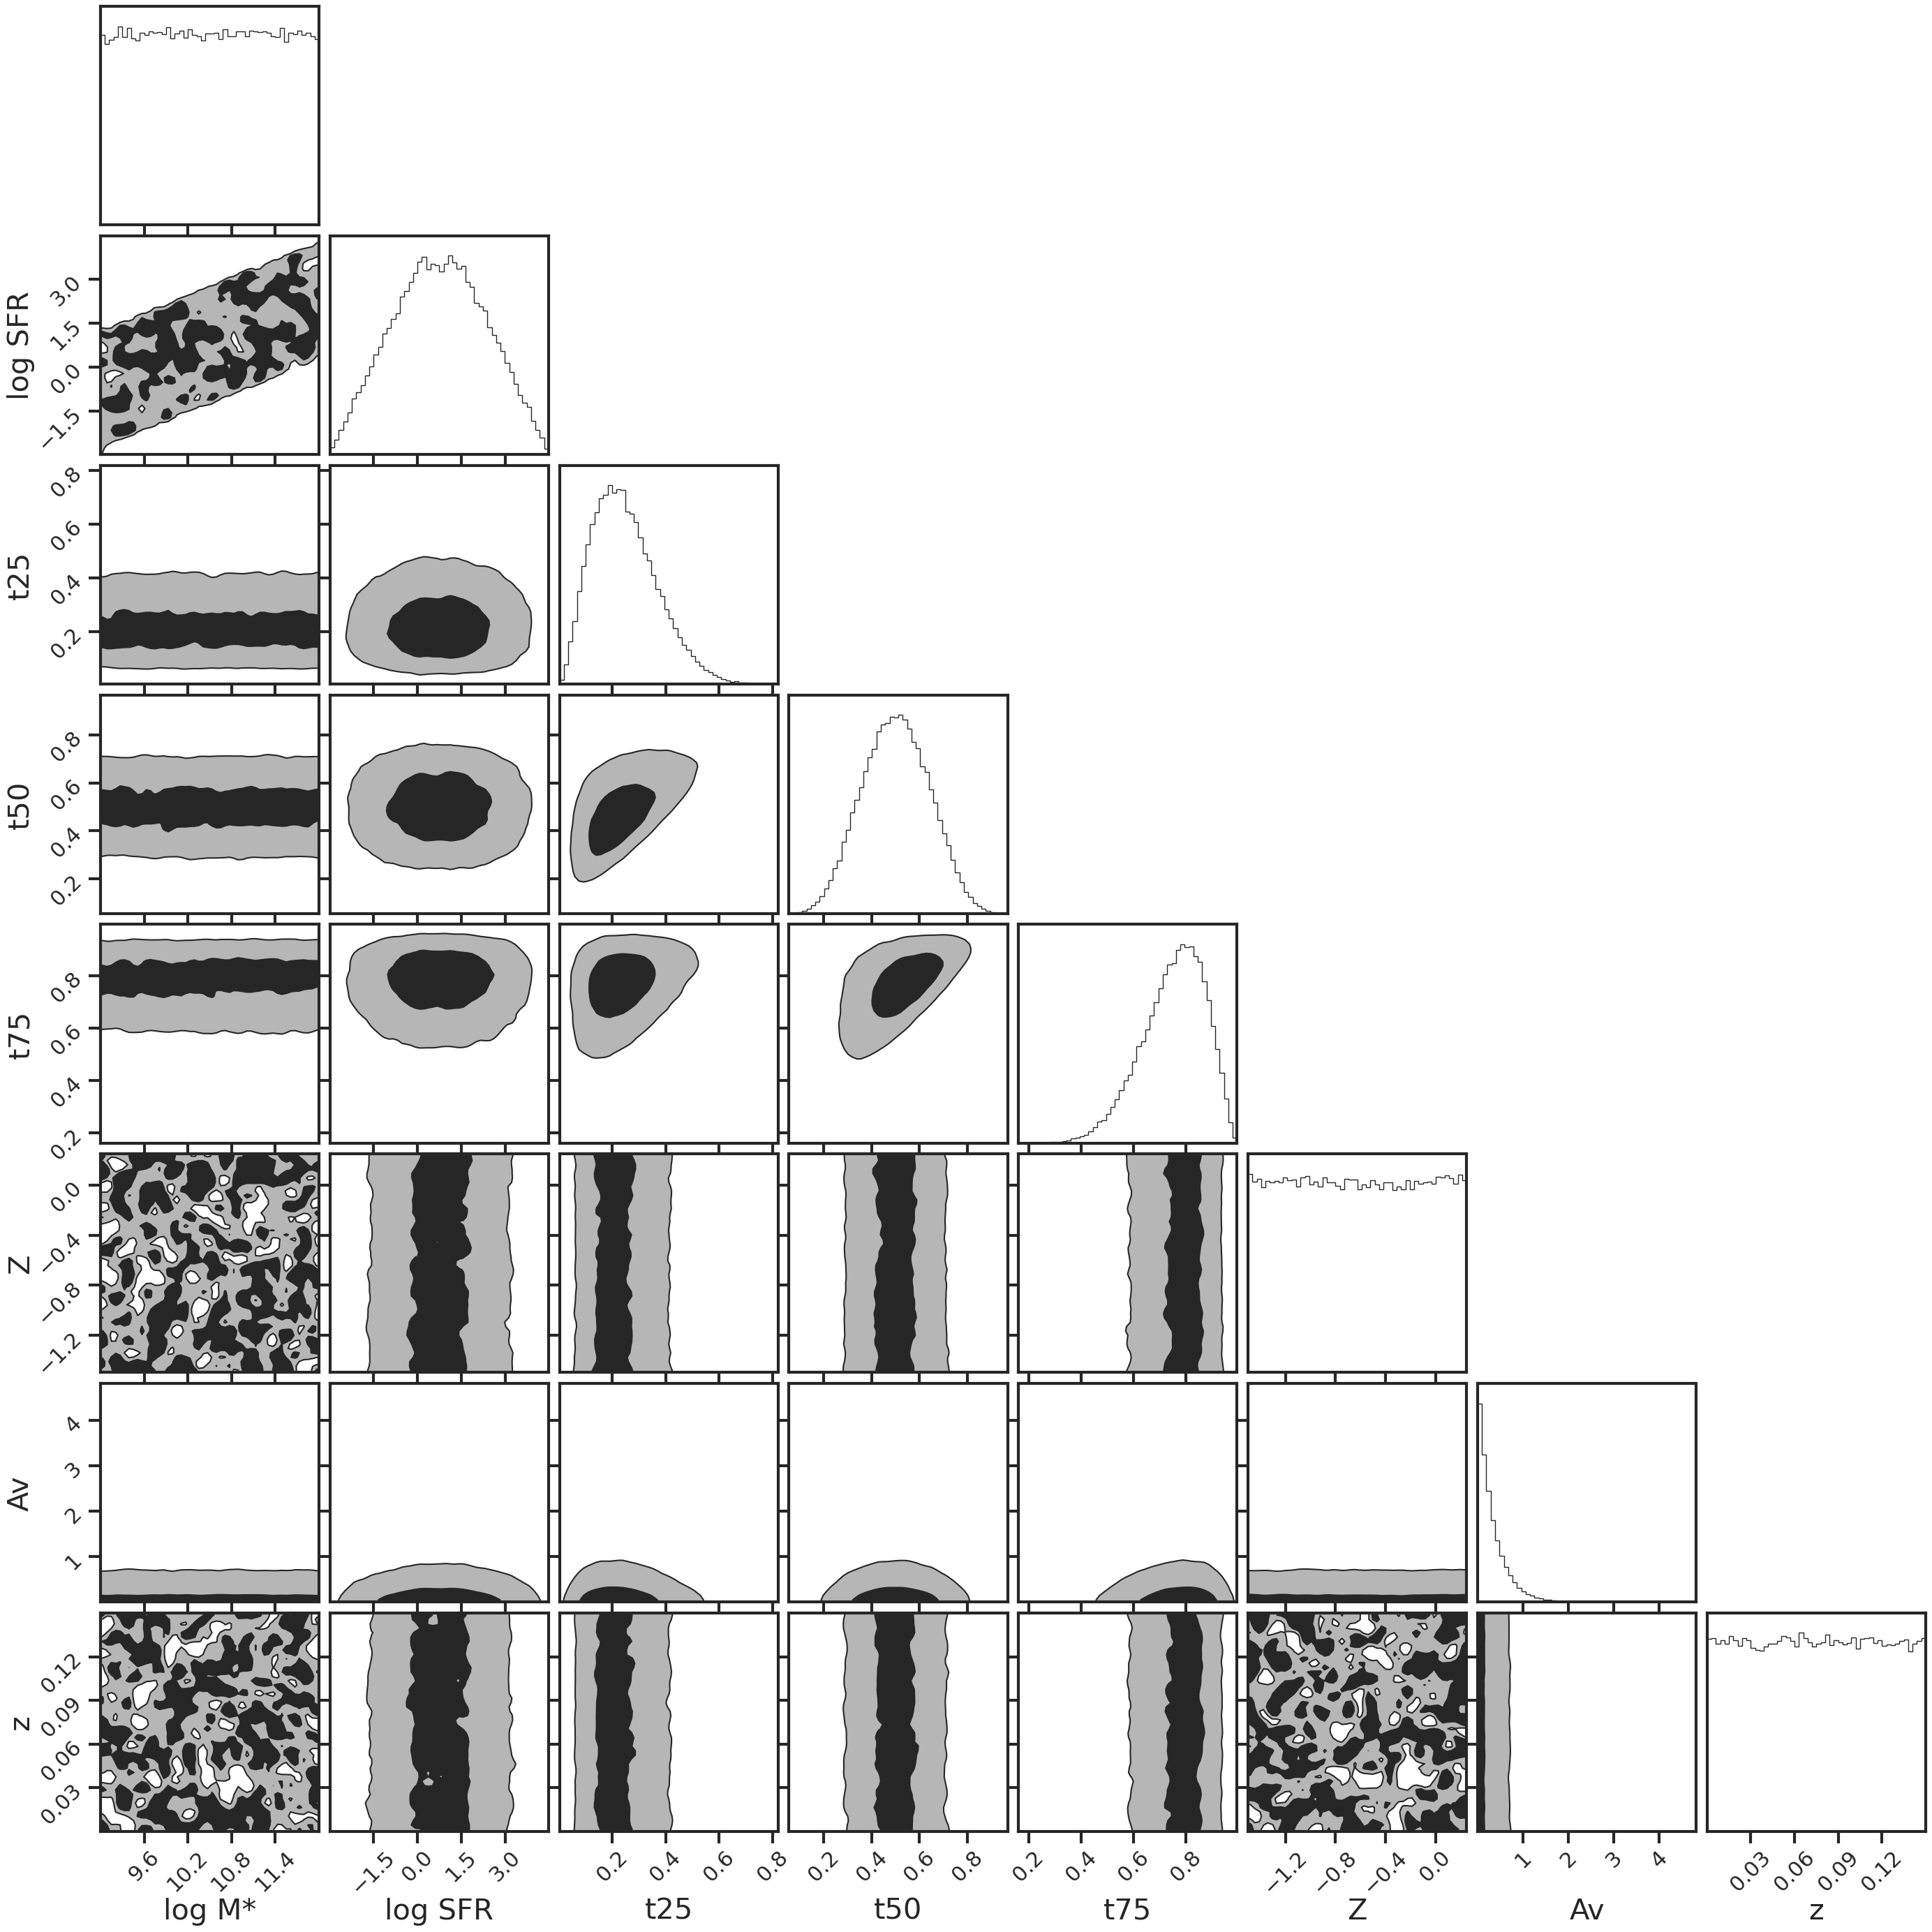

In [6]:
priors = db.Priors()

priors.tx_alpha = Nparam
priors.Nparam = Nparam

priors.z_min = z_min
priors.z_max = z_max

priors.plot_prior_distributions()

## Generate Atlas

This code first checks if atlas at that redshift range and Nparam exists. It will only generate the atlas if redshift range or Nparam were updated. 
> One must keep in mind to delete existing atlas to generate a new one if other dependent variable(s), like priors.tx_alpha, were changed.

In [7]:
# Atlas
N_pregrid = 10000
priors.Nparam = Nparam
path = 'pregrids/'

# CHECK IF PREGRIDS DIRECTORY EXIST
if not os.path.exists("pregrids"):
    os.makedirs("pregrids")
    print("New directory 'pregrids' created")
    
# FILENAME GENERATOR
ATLAS_fname = "atlas_z_" + "".join(str(z_min).split(".")) + "_" + "".join(str(z_max).split("."))
check_fname = ATLAS_fname + "_" + str(N_pregrid) + "_" + "Nparam" + "_" + str(Nparam) + ".dbatlas"

if os.path.exists(path + check_fname):
    print("The atlas with this name already exists.\nGenerate atlas skipped.")
else:
    db.generate_atlas(N_pregrid = N_pregrid, 
                priors = priors, 
                fname = ATLAS_fname, store=True, path='pregrids/',
                filter_list = filter_list, filt_dir = filt_dir)

# Load Atlas for later use
atlas = db.load_atlas(ATLAS_fname, N_pregrid = N_pregrid, N_param = priors.Nparam, path = path)


The atlas with this name already exists.
Generate atlas skipped.


# PART II: Data Retrieval

Specifying Criteria :

- `num_of_galaxies`: Specify the number of galaxies to be queried. The greater the value of this variable, the longer it will take to retrieve the information
- `truth_type`: Specify whether stars or galaxies to be queried
- `r_mag`: Specify the least magnitude



**Important Note: Changes to these variables will not query the data again if its processed before. If it's required to query the data again, then delete the appropriate query file from `query` directory.**


TAP query to collect galaxies from Truth and Object catalog that match the criteria above

In [8]:
# INITIALIZE PARAMETERS

num_of_galaxies = 5000
truth_type = 1
r_mag = 17.5
detect_isPrimary = 1
r_extendedness = 1

In [9]:
query = "SELECT TOP " + str(num_of_galaxies) + \
        "ts.ra AS ts_ra, " + \
        "ts.dec AS ts_dec, " + \
        "scisql_nanojanskyToAbMag(ts.flux_g) AS ts_convmag_g, " + \
        "scisql_nanojanskyToAbMag(ts.flux_r) AS ts_convmag_r, " + \
        "scisql_nanojanskyToAbMag(obj.g_cModelFlux) AS obj_convmag_g, " + \
        "scisql_nanojanskyToAbMag(obj.r_cModelFlux) AS obj_convmag_r, " + \
        "ts.mag_r AS ts_mag_r, " + \
        "ts.redshift AS ts_redshift, " + \
        "ts.flux_u AS ts_flux_u, " + \
        "ts.flux_g AS ts_flux_g, " + \
        "ts.flux_r AS ts_flux_r, " + \
        "ts.flux_i AS ts_flux_i, " + \
        "ts.flux_z AS ts_flux_z, " + \
        "ts.flux_y AS ts_flux_y, " + \
        "obj.coord_ra AS obj_coord_ra, " + \
        "obj.coord_dec AS obj_coord_dec, " + \
        "scisql_nanojanskyToAbMag(obj.r_cModelFlux) AS obj_cModelMag_r, " + \
        "obj.u_cModelFlux AS obj_u_cModelFlux, " + \
        "obj.g_cModelFlux AS obj_g_cModelFlux, " + \
        "obj.r_cModelFlux AS obj_r_cModelFlux, " + \
        "obj.i_cModelFlux AS obj_i_cModelFlux, " + \
        "obj.z_cModelFlux AS obj_z_cModelFlux, " + \
        "obj.y_cModelFlux AS obj_y_cModelFlux, " + \
        "obj.u_cModelFluxErr AS obj_u_cModelFluxErr, " + \
        "obj.g_cModelFluxErr AS obj_g_cModelFluxErr, " + \
        "obj.r_cModelFluxErr AS obj_r_cModelFluxErr, " + \
        "obj.i_cModelFluxErr AS obj_i_cModelFluxErr, " + \
        "obj.z_cModelFluxErr AS obj_z_cModelFluxErr, " + \
        "obj.y_cModelFluxErr AS obj_y_cModelFluxErr " + \
        "FROM dp02_dc2_catalogs.MatchesTruth AS mt " + \
        "JOIN dp02_dc2_catalogs.TruthSummary AS ts ON mt.id_truth_type = ts.id_truth_type " + \
        "JOIN dp02_dc2_catalogs.Object AS obj ON mt.match_objectId = obj.objectId " + \
        "WHERE ts.truth_type = " + str(truth_type) + \
        "AND ts.redshift <= " + str(z_max) + \
        "AND ts.redshift >= " + str(z_min) + \
        "AND ts.mag_r < " + str(r_mag) + \
        "AND obj.detect_isPrimary = " + str(detect_isPrimary) + \
        "AND obj.r_extendedness = " + str(r_extendedness)
print(query)

SELECT TOP 5000ts.ra AS ts_ra, ts.dec AS ts_dec, scisql_nanojanskyToAbMag(ts.flux_g) AS ts_convmag_g, scisql_nanojanskyToAbMag(ts.flux_r) AS ts_convmag_r, scisql_nanojanskyToAbMag(obj.g_cModelFlux) AS obj_convmag_g, scisql_nanojanskyToAbMag(obj.r_cModelFlux) AS obj_convmag_r, ts.mag_r AS ts_mag_r, ts.redshift AS ts_redshift, ts.flux_u AS ts_flux_u, ts.flux_g AS ts_flux_g, ts.flux_r AS ts_flux_r, ts.flux_i AS ts_flux_i, ts.flux_z AS ts_flux_z, ts.flux_y AS ts_flux_y, obj.coord_ra AS obj_coord_ra, obj.coord_dec AS obj_coord_dec, scisql_nanojanskyToAbMag(obj.r_cModelFlux) AS obj_cModelMag_r, obj.u_cModelFlux AS obj_u_cModelFlux, obj.g_cModelFlux AS obj_g_cModelFlux, obj.r_cModelFlux AS obj_r_cModelFlux, obj.i_cModelFlux AS obj_i_cModelFlux, obj.z_cModelFlux AS obj_z_cModelFlux, obj.y_cModelFlux AS obj_y_cModelFlux, obj.u_cModelFluxErr AS obj_u_cModelFluxErr, obj.g_cModelFluxErr AS obj_g_cModelFluxErr, obj.r_cModelFluxErr AS obj_r_cModelFluxErr, obj.i_cModelFluxErr AS obj_i_cModelFluxErr, 

## Asynchronous Query

Sometimes, the data querying can be time expensive. Using asynchronous query enables to work on the notebook while the data is getting collected. The cell below performs the data retrieval. It will show the time it took and a message once the data is retrieved

In [10]:
query_fname = "TAP-top" + str(num_of_galaxies) + "_z_" + "".join(str(z_min).split(".")) + "_" + "".join(str(z_max).split(".")) + ".pkl"

# CHECK IF QUERY DIRECTORY EXIST
if not os.path.exists("query"):
    os.makedirs("query")
    print("New directory 'query' created")

# GENERATE AND/OR SAVE QUERY
if os.path.exists("query/" + query_fname):
    print("Query with input parameters already exists.\nLoading query.")
    
    denseBCG = pandas.read_pickle("query/" + query_fname)
else:
    print("Querying data asynchronously")
    job = service.submit_job(query)
    job.run()

    job.wait(phases=['COMPLETED', 'ERROR'])
    print('Job phase is', job.phase)
    job.raise_if_error()
    
    results = job.fetch_result()
    denseBCG = results.to_table().to_pandas()
    
    denseBCG.to_pickle("query/" + query_fname)

Query with input parameters already exists.
Loading query.


In [11]:
denseBCG

,ts_ra,ts_dec,ts_convmag_g,ts_convmag_r,obj_convmag_g,obj_convmag_r,ts_mag_r,ts_redshift,ts_flux_u,ts_flux_g,...,obj_u_cModelFluxErr,obj_g_cModelFluxErr,obj_r_cModelFluxErr,obj_i_cModelFluxErr,obj_z_cModelFluxErr,obj_y_cModelFluxErr,Distance (in pc),Absolute Magnitude,Truth DB Mass,Object DB Mass
0,60.554572,-35.974145,15.762368,14.740977,16.007377,15.034799,14.741000,0.104260,381280.000000,1799090.0,...,458.345928,263.824253,318.427956,537.607145,1035.811103,1338.488548,448108832.0,-23.515919,0,11.9635
1,59.821802,-34.950849,15.742013,14.835395,16.019324,15.117949,14.835400,0.101693,415811.000000,1833140.0,...,660.144749,379.466365,420.338633,674.442631,1609.565587,2463.048269,437075872.0,-23.367386,0,11.7945
2,53.064454,-39.517537,15.114445,14.218996,15.350295,14.488032,14.219000,0.076375,723696.000000,3267550.0,...,477.374559,341.344426,396.037278,587.281312,1230.732283,1561.113514,328257568.0,-23.362074,0,12.0395
3,70.277199,-36.454786,15.235795,14.348898,15.513194,14.629675,14.348900,0.073293,631747.000000,2922010.0,...,532.396826,377.312138,384.551334,566.635249,1037.670202,1648.671251,315013728.0,-23.142750,0,12.0165
4,68.649370,-35.676167,16.361218,15.320089,16.751348,15.761973,15.320100,0.114330,217822.000000,1036370.0,...,333.615676,193.882968,234.842134,344.074845,689.837900,1214.459164,491389632.0,-23.137032,0,11.6635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,65.400281,-34.084658,17.901020,17.495874,19.103825,18.640370,17.495899,0.012174,92799.898438,250953.0,...,317.514179,139.591376,148.892717,292.605294,678.262319,1132.722477,52325068.0,-16.097652,0,9.6085
4996,68.627685,-34.461394,17.425300,16.933136,18.069550,17.586900,16.933100,0.009240,164275.000000,388938.0,...,310.587409,155.820963,163.243701,280.940539,672.755063,1032.465483,39711316.0,-16.061472,0,10.1425
4997,58.751332,-38.999327,17.531696,16.942506,17.241501,16.641650,16.942499,0.009226,113336.000000,352632.0,...,435.142729,194.836950,221.212328,352.675953,860.447458,1245.602129,39653720.0,-16.048922,0,10.6565
4998,58.604430,-38.669434,17.555282,17.187168,17.382860,16.987013,17.187201,0.010069,129291.000000,345054.0,...,338.136269,160.042029,173.749781,245.385377,583.515110,869.691553,43277360.0,-15.994104,0,10.1785


# PART III: Data Processing

Calculating distance and absoloute magnitude for every galaxy using broadcasting functionality of `Pandas`

In [12]:
denseBCG['Distance (in pc)'] = (3e5 * 1e6 * denseBCG['ts_redshift']) / 69.8
denseBCG['Absolute Magnitude'] = denseBCG["ts_mag_r"] - 5 * np.log10(denseBCG['Distance (in pc)'] / 10.0)

In [13]:
denseBCG=denseBCG.sort_values(by='Absolute Magnitude', ascending=True)
denseBCG=denseBCG.reset_index()
denseBCG=denseBCG.drop(columns=['index'])
denseBCG

,ts_ra,ts_dec,ts_convmag_g,ts_convmag_r,obj_convmag_g,obj_convmag_r,ts_mag_r,ts_redshift,ts_flux_u,ts_flux_g,...,obj_u_cModelFluxErr,obj_g_cModelFluxErr,obj_r_cModelFluxErr,obj_i_cModelFluxErr,obj_z_cModelFluxErr,obj_y_cModelFluxErr,Distance (in pc),Absolute Magnitude,Truth DB Mass,Object DB Mass
0,60.554572,-35.974145,15.762368,14.740977,16.007377,15.034799,14.741000,0.104260,381280.000000,1799090.0,...,458.345928,263.824253,318.427956,537.607145,1035.811103,1338.488548,448108832.0,-23.515919,0,11.9635
1,59.821802,-34.950849,15.742013,14.835395,16.019324,15.117949,14.835400,0.101693,415811.000000,1833140.0,...,660.144749,379.466365,420.338633,674.442631,1609.565587,2463.048269,437075872.0,-23.367386,0,11.7945
2,53.064454,-39.517537,15.114445,14.218996,15.350295,14.488032,14.219000,0.076375,723696.000000,3267550.0,...,477.374559,341.344426,396.037278,587.281312,1230.732283,1561.113514,328257568.0,-23.362074,0,12.0395
3,70.277199,-36.454786,15.235795,14.348898,15.513194,14.629675,14.348900,0.073293,631747.000000,2922010.0,...,532.396826,377.312138,384.551334,566.635249,1037.670202,1648.671251,315013728.0,-23.142750,0,12.0165
4,68.649370,-35.676167,16.361218,15.320089,16.751348,15.761973,15.320100,0.114330,217822.000000,1036370.0,...,333.615676,193.882968,234.842134,344.074845,689.837900,1214.459164,491389632.0,-23.137032,0,11.6635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,65.400281,-34.084658,17.901020,17.495874,19.103825,18.640370,17.495899,0.012174,92799.898438,250953.0,...,317.514179,139.591376,148.892717,292.605294,678.262319,1132.722477,52325068.0,-16.097652,0,9.6085
4996,68.627685,-34.461394,17.425300,16.933136,18.069550,17.586900,16.933100,0.009240,164275.000000,388938.0,...,310.587409,155.820963,163.243701,280.940539,672.755063,1032.465483,39711316.0,-16.061472,0,10.1425
4997,58.751332,-38.999327,17.531696,16.942506,17.241501,16.641650,16.942499,0.009226,113336.000000,352632.0,...,435.142729,194.836950,221.212328,352.675953,860.447458,1245.602129,39653720.0,-16.048922,0,10.6565
4998,58.604430,-38.669434,17.555282,17.187168,17.382860,16.987013,17.187201,0.010069,129291.000000,345054.0,...,338.136269,160.042029,173.749781,245.385377,583.515110,869.691553,43277360.0,-15.994104,0,10.1785


## Data Processing using Dense Basis

The program will check the existance of the processed data in the `DV_Dataframe` directory. If it exists, then it will simply load and print "Loading existing data from Truth/Object: xxx.pkl"

If data processing is required even though it loads, then navigate into `DV_Dataframe` to delete the older version to process it again.

In [14]:
# CHECK IF DV_DATAFRAME DIRECTORY EXISTS
if not os.path.exists("DV_Dataframe"):
    os.makedirs("DV_Dataframe")
    print("New directory 'DV_Dataframe' created")


# FOR TRUTH DATA
if not os.path.exists("DV_Dataframe/" + "Truth"):
    os.makedirs("DV_Dataframe/" + "Truth")
    print("New directory 'Truth' created")

# FOR OBJECT DATA
if not os.path.exists("DV_Dataframe/" + "Object"):
    os.makedirs("DV_Dataframe/" + "Object")
    print("New directory 'Object' created")

# CHECK IF CHILD DIRECTORY EXISTS
ts_dv_fname = "DV_Dataframe/Truth/" + "z_" + "".join(str(z_min).split(".")) + "_" + "".join(str(z_max).split(".")) + "_Nparam_" + str(Nparam)
if not os.path.exists(ts_dv_fname):
    os.makedirs(ts_dv_fname)
    print("New child directory " + "z_" + "".join(str(z_min).split(".")) + "_" + "".join(str(z_max).split(".")) + "_Nparam_" + str(Nparam) + " created in Truth")

obj_dv_fname = "DV_Dataframe/Object/" + "z_" + "".join(str(z_min).split(".")) + "_" + "".join(str(z_max).split(".")) + "_Nparam_" + str(Nparam)
if not os.path.exists(obj_dv_fname):
    os.makedirs(obj_dv_fname)
    print("New child directory " + "z_" + "".join(str(z_min).split(".")) + "_" + "".join(str(z_max).split(".")) + "_Nparam_" + str(Nparam) + " created in Object")


# CHECK IF DATA HAS BEEN PROCESSED EARLIER
files = os.listdir(ts_dv_fname)
for file in files:
    if file[0:4] == "DV_0":
        print("Loading existing data for Truth : " + file)
        truth = pandas.read_pickle(ts_dv_fname + "/" + file)


# FOR OBJECT DATA
files = os.listdir(obj_dv_fname)
for file in files:
    if file[0:4] == "DV_0":
        print("Loading existing data for Object : " + file)
        obj = pandas.read_pickle(obj_dv_fname + "/" + file)


Loading existing data for Truth : DV_0_4999.pkl
Loading existing data for Object : DV_0_4999.pkl


If it says "Loading existing data from Truth/Object: xxx.pkl", then you can skip either one or both of the loops, and **skip to the next section**

**Important Note: if the loop processing begins, then it can overwrite existing files. It can be time expensive if the loop once starts, it's better to wait until it finishes processing**

The loops later on are designed to collect galactic properties like stellar mass, dust, metallicity of all the galaxies that are queried

This section helps dividing the computation time by processing the galaxies in smaller groups. The size of these groups can be changed by changing `offset`

While deciding the size of offset, keep in mind that it takes about **0.8 seconds to process each galaxy**. The size of the subset can be changed based on the requirements

The processing loops will register deletion and creation of new files, suggesting the incorporation of new processed data into existing dataset that is ready for retrieval

These subset are periodically saved and can be used to visualize the plots using `DB_Visualizer.ipynb` while the data is still being processed

### Truth-Catalog Loop

In [2]:
# Change the offset acordingly
offset = 500

# This is used by the program to register the start and end of data processing. No need to change these variables
range_min = -offset
range_max = 0

# Used later for Star Formation History
denseBCG['Truth DB Mass'] = [0] * len(denseBCG)

NameError: name 'denseBCG' is not defined

In [26]:
# TRUTH SUMMARY DATA PROCESSING #


# CREATE DATAFRAME FOR VISUALIZATION
if Nparam == 3:
    columns = ['Mass', 'SFR', 'Z', 't75','Burst', 'Dust']
else:
    columns = ['Mass', 'SFR', 'Z', 'Burst', 'Dust']
truth = pandas.DataFrame(columns = columns, index = range(len(denseBCG)))

ts_lookback=[]
ts_sfh=[]
ts_starburst=[]
ts_bestfit=[]

while range_max < len(denseBCG):
    range_min += offset
    range_max += offset
    if range_max >= len(denseBCG):
        range_max = len(denseBCG)

    
    # PROCESSING BEINGS
    for i in range(range_min, range_max):

        # RETRIEVING FLUX INFORMATION FROM THE QUERY
        filters=['u','g','r','i','z','y']
        ts_obs_sed_list=[]
        ts_obs_err_list=[]
        for letter in filters:
            ts_flux = denseBCG[F"ts_flux_{letter}"][i] / 1000
            ts_flux_err = ts_flux*0.1
       
            ts_obs_sed_list.append(ts_flux)
            ts_obs_err_list.append(ts_flux_err)
       
        ts_obs_sed = np.array(ts_obs_sed_list)
        ts_obs_err = np.array(ts_obs_err_list)

        # PASSING FLUX INFORMATION TO DENSE BASIS FOR COMPUTATION
        ts_sedfit = db.SedFit(ts_obs_sed, ts_obs_err, atlas, fit_mask=[])
        ts_sedfit.evaluate_likelihood()
        ts_sedfit.evaluate_posterior_percentiles()

        result = ts_sedfit.evaluate_posterior_SFH(ts_sedfit.z[0])
        sfh_50 = result[0]
        common_time = result[3]
        
        x=np.amax(common_time)-common_time
        y=sfh_50
        coefs = poly.polyfit(x, y, 6)
        ffit = poly.polyval(x, coefs)
        peaks=find_peaks(ffit)
        starburst=len(peaks)

        ts_lookback.append(x)
        ts_sfh.append(y)
        ts_starburst.append(starburst)
        ts_bestfit.append(ffit)
        
        truth['Burst'][i] = len(peaks)
        
        truth['Mass'][i] = ts_sedfit.mstar[0]
        denseBCG['Truth DB Mass'][i] = ts_sedfit.mstar[0]
        
        truth['SFR'][i] = ts_sedfit.sfr[0]
        truth['Z'][i] = ts_sedfit.Z[0]
        truth['Dust'][i] = ts_sedfit.Av[0]

        if Nparam == 3:
            truth['t75'][i] = ts_sedfit.sfh_tuple[0,5]

    
    # REMOVING PREVIOUS VERSION
    previous_dv_file = "DV_" + "0" + "_" + str(range_max - offset - 1) + ".pkl"
    if os.path.exists(ts_dv_fname + "/" + previous_dv_file):
        os.remove(ts_dv_fname + "/" + previous_dv_file)
        print("Successfully removed previous occurance of the data file : " + previous_dv_file)

    # SAVING UPDATED VERSION
    new_dv_file = "DV_" + "0" + "_" + str(range_max - 1) + ".pkl"
    truth.to_pickle(ts_dv_fname + "/" + new_dv_file)
    print("Generating updated dataframe : " + new_dv_file)
    # if range_max == len(denseBCG):
    #     break


print("Data processing complete.")


Generating updated dataframe : DV_0_499.pkl
Successfully removed previous occurance of the data file : DV_0_499.pkl
Generating updated dataframe : DV_0_999.pkl
Successfully removed previous occurance of the data file : DV_0_999.pkl
Generating updated dataframe : DV_0_1499.pkl
Successfully removed previous occurance of the data file : DV_0_1499.pkl
Generating updated dataframe : DV_0_1999.pkl
Successfully removed previous occurance of the data file : DV_0_1999.pkl
Generating updated dataframe : DV_0_2499.pkl
Successfully removed previous occurance of the data file : DV_0_2499.pkl
Generating updated dataframe : DV_0_2999.pkl
Successfully removed previous occurance of the data file : DV_0_2999.pkl
Generating updated dataframe : DV_0_3499.pkl
Successfully removed previous occurance of the data file : DV_0_3499.pkl
Generating updated dataframe : DV_0_3999.pkl
Successfully removed previous occurance of the data file : DV_0_3999.pkl
Generating updated dataframe : DV_0_4499.pkl
Successfully re

### Object-Catalog Loop

In [27]:
offset = 500

# This is used by the program to register the start and end of data processing. No need to change these variables
range_min = -offset
range_max = 0

# Used later for Star Formation History
denseBCG['Object DB Mass'] = [0] * len(denseBCG)

In [28]:
# OBJECT SUMMARY DATA PROCESSING #


# CREATE DATAFRAME FOR VISUALIZATION
if Nparam == 3:
    columns = ['Mass', 'SFR', 'Z', 't75','Burst', 'Dust']
else:
    columns = ['Mass', 'SFR', 'Z', 'Burst', 'Dust']
obj = pandas.DataFrame(columns = columns, index = range(len(denseBCG)))

obj_lookback=[]
obj_sfh=[]
obj_starburst=[]
obj_bestfit=[]

while range_max < len(denseBCG):
    range_min += offset
    range_max += offset
    if range_max >= len(denseBCG):
        range_max = len(denseBCG)

    
    # PROCESSING BEINGS
    for i in range(range_min, range_max):

        # RETRIEVING FLUX INFORMATION FROM THE QUERY
        filters=['u','g','r','i','z','y']
        obj_obs_sed_list=[]
        obj_obs_err_list=[]
        for letter in filters:
            obj_flux=denseBCG[F"obj_{letter}_cModelFlux"][i] / 1000
            obj_flux_err=obj_flux*0.1
   
            obj_obs_sed_list.append(obj_flux)
            obj_obs_err_list.append(obj_flux_err)
 
        obj_obs_sed=np.array(obj_obs_sed_list)
        obj_obs_err=np.array(obj_obs_err_list)

        # PASSING FLUX INFORMATION TO DENSE BASIS FOR COMPUTATION
        obj_sedfit = db.SedFit(obj_obs_sed, obj_obs_err, atlas, fit_mask=[])
        obj_sedfit.evaluate_likelihood()
        obj_sedfit.evaluate_posterior_percentiles()

        result = obj_sedfit.evaluate_posterior_SFH(obj_sedfit.z[0])
        sfh_50 = result[0]
        common_time = result[3]

        x=np.amax(common_time)-common_time
        y=sfh_50
        coefs = poly.polyfit(x, y, 6)
        ffit = poly.polyval(x, coefs)
        peaks=find_peaks(ffit)
        starburst=len(peaks)

        obj_lookback.append(x)
        obj_sfh.append(y)
        obj_starburst.append(starburst)
        obj_bestfit.append(ffit)

        obj['Burst'][i] = len(peaks)
        
        obj['Mass'][i] = obj_sedfit.mstar[0]
        denseBCG['Object DB Mass'][i] = obj_sedfit.mstar[0]
        
        obj['SFR'][i] = obj_sedfit.sfr[0]
        obj['Z'][i] = obj_sedfit.Z[0]
        obj['Dust'][i] = obj_sedfit.Av[0]

        if Nparam == 3:
            obj['t75'][i] = obj_sedfit.sfh_tuple[0,5]

    
    # REMOVING PREVIOUS VERSION
    previous_dv_file = "DV_" + "0" + "_" + str(range_max - offset - 1) + ".pkl"
    if os.path.exists(obj_dv_fname + "/" + previous_dv_file):
        os.remove(obj_dv_fname + "/" + previous_dv_file)
        print("Successfully removed previous occurance of the data file : " + previous_dv_file)

    # SAVING UPDATED VERSION
    new_dv_file = "DV_" + "0" + "_" + str(range_max - 1) + ".pkl"
    obj.to_pickle(obj_dv_fname + "/" + new_dv_file)
    print("Generating updated dataframe : " + new_dv_file)
    # if range_max == len(denseBCG):
    #     break


print("Data processing complete.")


Generating updated dataframe : DV_0_499.pkl
Successfully removed previous occurance of the data file : DV_0_499.pkl
Generating updated dataframe : DV_0_999.pkl
Successfully removed previous occurance of the data file : DV_0_999.pkl
Generating updated dataframe : DV_0_1499.pkl
Successfully removed previous occurance of the data file : DV_0_1499.pkl
Generating updated dataframe : DV_0_1999.pkl
Successfully removed previous occurance of the data file : DV_0_1999.pkl
Generating updated dataframe : DV_0_2499.pkl
Successfully removed previous occurance of the data file : DV_0_2499.pkl
Generating updated dataframe : DV_0_2999.pkl
Successfully removed previous occurance of the data file : DV_0_2999.pkl
Generating updated dataframe : DV_0_3499.pkl
Successfully removed previous occurance of the data file : DV_0_3499.pkl
Generating updated dataframe : DV_0_3999.pkl
Successfully removed previous occurance of the data file : DV_0_3999.pkl
Generating updated dataframe : DV_0_4499.pkl
Successfully re

## Saving changes to `denseBCG`

In [3]:
denseBCG.to_pickle("query/" + query_fname)

NameError: name 'denseBCG' is not defined